In [1]:
!pip install -q matplotlib-venn
!pip install eli5

     |████████████████████████████████| 112kB 2.8MB/s 


In [0]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

import eli5
from eli5.sklearn import PermutationImportance

from ast import literal_eval
from tqdm import tqdm_notebook

In [11]:
cd "/content/drive/My Drive/Colab Notebooks/dw_matrix"

/content/drive/My Drive/Colab Notebooks/dw_matrix


In [14]:
ls data

men_shoes_usd.csv  shoes_prices.csv


In [15]:
df = pd.read_csv('data/men_shoes_usd.csv', low_memory=False)
df.shape

(18280, 48)

In [16]:
df.columns

Index(['id', 'asins', 'brand', 'categories', 'colors', 'count', 'dateadded',
       'dateupdated', 'descriptions', 'dimension', 'ean', 'features',
       'flavors', 'imageurls', 'isbn', 'keys', 'manufacturer',
       'manufacturernumber', 'merchants', 'name', 'prices_amountmin',
       'prices_amountmax', 'prices_availability', 'prices_color',
       'prices_condition', 'prices_count', 'prices_currency',
       'prices_dateadded', 'prices_dateseen', 'prices_flavor', 'prices_issale',
       'prices_merchant', 'prices_offer', 'prices_returnpolicy',
       'prices_shipping', 'prices_size', 'prices_source', 'prices_sourceurls',
       'prices_warranty', 'quantities', 'reviews', 'sizes', 'skus',
       'sourceurls', 'upc', 'vin', 'websiteids', 'weight'],
      dtype='object')

In [17]:
mean_price = np.mean( df['prices_amountmin'])
mean_price

93.53952188183217

In [18]:
y_true = df['prices_amountmin']
y_pred = [mean_price] * y_true.shape[0]

mean_absolute_error(y_true, y_pred)

63.968341227870624

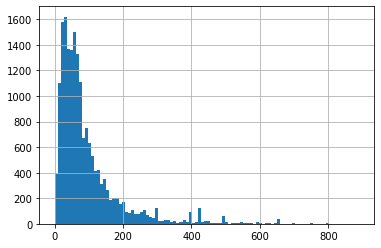

In [19]:
df['prices_amountmin'].hist(bins=100)

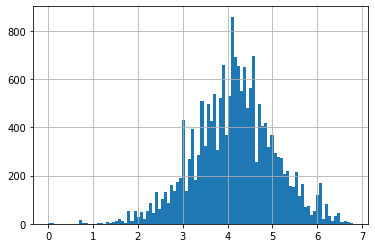

In [20]:
np.log1p(df['prices_amountmin']) .hist(bins=100)

In [21]:
y_true = df['prices_amountmin']
price_log_mean = np.expm1(np.mean( np.log1p(y_true)))
y_pred = [price_log_mean] * y_true.shape[0]

mean_absolute_error(y_true, y_pred)

58.03539547661041

In [22]:
df.columns

Index(['id', 'asins', 'brand', 'categories', 'colors', 'count', 'dateadded',
       'dateupdated', 'descriptions', 'dimension', 'ean', 'features',
       'flavors', 'imageurls', 'isbn', 'keys', 'manufacturer',
       'manufacturernumber', 'merchants', 'name', 'prices_amountmin',
       'prices_amountmax', 'prices_availability', 'prices_color',
       'prices_condition', 'prices_count', 'prices_currency',
       'prices_dateadded', 'prices_dateseen', 'prices_flavor', 'prices_issale',
       'prices_merchant', 'prices_offer', 'prices_returnpolicy',
       'prices_shipping', 'prices_size', 'prices_source', 'prices_sourceurls',
       'prices_warranty', 'quantities', 'reviews', 'sizes', 'skus',
       'sourceurls', 'upc', 'vin', 'websiteids', 'weight'],
      dtype='object')

In [0]:
df['brand_cat'] = df['brand'].factorize()[0]
df['manufacturer_cat'] = df['manufacturer'].factorize()[0]
df['categories_m'] = df['categories'].factorize()[0]
df['weight_m'] = df['weight'].factorize()[0]
df['reviews_m'] = df['reviews'].factorize()[0]

In [24]:
feats = ['brand_cat']
X = df[ feats ].values
y = df['prices_amountmin'].values

model = DecisionTreeRegressor(max_depth=5)

scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error')
np.mean(scores), np.std(scores)

(-58.38655694633361, 4.223555478221712)

In [0]:
def run_model(feats):
  X = df[ feats ].values
  y = df['prices_amountmin'].values

  model = DecisionTreeRegressor(max_depth=5)

  scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error')
  return np.mean(scores), np.std(scores)

In [31]:
run_model(['brand_cat'])

(-58.38655694633361, 4.223555478221712)

In [27]:
run_model(['manufacturer_cat'])

(-63.133649278023746, 3.394307434888982)

In [28]:
run_model(['brand_cat', 'manufacturer_cat'])

(-58.53930419908596, 4.31122323161543)

In [29]:
run_model(['brand_cat', 'manufacturer_cat', 'categories_m', 'weight_m', 'reviews_m'])

(-58.70134898114234, 6.194957048143389)

In [0]:
def run_model(feats, model = DecisionTreeRegressor(max_depth=5)):
  X = df[ feats ].values
  y = df['prices_amountmin'].values

  scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error')
  return np.mean(scores), np.std(scores)

In [34]:
model = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=0)
run_model(['brand_cat'], model)

(-57.47223572384038, 4.328288468270897)

In [37]:
df['brand_cat'] = df['brand'].map(lambda x: str(x).lower()).factorize()[0]
run_model(['brand_cat'], model)

(-57.31783843165656, 4.181246596160967)

In [0]:
def parse_features(x):
  output_dict = {}
  if str(x) == 'nan':return output_dict

  features = literal_eval(x.replace('\\"', '"'))
  for item in features:
    key = item['key'].lower().strip()
    value = item['value'][0].lower().strip()

    output_dict[key] = value
    
  return output_dict

df['features_parsed'] = df['features'].map(parse_features)

In [47]:
keys = set()


df['features_parsed'].map( lambda x: keys.update(x.keys()))

len(keys)

476

In [60]:
def get_name_feat(key):
  return 'feat_' + key

for key in tqdm_notebook(keys):
  df[get_name_feat(key)] = df.features_parsed.map(lambda feats: feats[key] if key in feats else np.nan)

In [61]:
df.columns

Index(['id', 'asins', 'brand', 'categories', 'colors', 'count', 'dateadded',
       'dateupdated', 'descriptions', 'dimension',
       ...
       'feat_productgroup', 'feat_szie', 'feat_crown',
       'feat_resolution megapixels', 'feat_product dimensions', 'feat_adidas',
       'feat_interior pockets', 'feat_mechanic', 'feat_target audience',
       'feat_walmart no.'],
      dtype='object', length=530)

In [0]:
 keys_stat = {}
 for key in keys:
  keys_stat[key] = df [ False == df[get_name_feat(key)].isnull() ].shape[0] / df.shape[0] * 100

In [74]:
{k:v for k,v in keys_stat.items() if v > 30}

{'brand': 48.62691466083151,
 'color': 47.784463894967175,
 'gender': 50.17505470459519,
 'manufacturer part number': 36.252735229759296,
 'material': 34.9070021881838}

In [63]:
df.shape[0]

18280

In [0]:
df['feat_brand_cat'] = df['feat_brand'].factorize()[0]
df['feat_color_cat'] = df['feat_color'].factorize()[0]
df['feat_gender_cat'] = df['feat_gender'].factorize()[0]
df['feat_manufacturer part number_cat'] = df['feat_manufacturer part number'].factorize()[0]
df['feat_material_cat'] = df['feat_material'].factorize()[0]
df['feat_sport'] = df['feat_sport'].factorize()[0]
df['feat_style'] = df['feat_style'].factorize()[0]

for key in keys:
  df[get_name_feat(key) + '_cat' ] = df[get_name_feat(key)].factorize()[0]

In [80]:
df ['brand'] = df['brand'].map(lambda x: str(x).lower())

df [df.brand != df.feat_brand].shape

#df [df.brand != df.feat_brand][['brand','feat_brand']].head()

(9434, 535)

In [114]:
feats_cat = [x for x in df.columns if 'cat' in x]
feats_cat

['categories',
 'brand_cat',
 'manufacturer_cat',
 'categories_m',
 'feat_shoe category',
 'feat_catalog',
 'feat_location - country',
 'feat_clothing category',
 'feat_location - city/state',
 'feat_recommended location',
 'feat_multi pack indicator',
 'feat_fabrication',
 'feat_certifications and listings',
 'feat_brand_cat',
 'feat_color_cat',
 'feat_gender_cat',
 'feat_manufacturer part number_cat',
 'feat_material_cat',
 'feat_euro size_cat',
 'feat_rise_cat',
 'feat_is orthopedic_cat',
 'feat_release_cat',
 'feat_free item_cat',
 'feat_fit_cat',
 'feat_age segment_cat',
 'feat_shipping weight_cat',
 'feat_product type_cat',
 'feat_sport_cat',
 'feat_charge time (minutes)_cat',
 'feat_navy blue_cat',
 'feat_frame material:_cat',
 'feat_style name_cat',
 'feat_is waterproof_cat',
 'feat_number of heat settings_cat',
 'feat_crystal_cat',
 'feat_hat style_cat',
 'feat_lined_cat',
 'feat_product #_cat',
 'feat_case diameter_cat',
 'feat_product name_cat',
 'feat_number of pieces_cat',

In [0]:
feats = [ 'feat_material_cat', 'feat_shape_cat', 'feat_sport', 'feat_style', 'brand_cat', 'feat_brand_cat', 'feat_color_cat' ]
feats += []
#feats += feats_cat
#feats = list(set(feats))

In [0]:
model = RandomForestRegressor(max_depth=25, n_estimators=100)
result = run_model(feats,model)

In [164]:

X = df [feats].values
y = df['prices_amountmin'].values

model = RandomForestRegressor(max_depth=5, n_estimators=100)

model.fit(X, y)

print(result)
perm = PermutationImportance(model, random_state=1).fit(X, y);
eli5.show_weights(perm, feature_names=feats)

(-46.22856043875703, 4.412399975829663)


Weight,Feature
0.2671 ± 0.0072,brand_cat
0.1132 ± 0.0073,feat_material_cat
0.0255 ± 0.0022,feat_shape_cat
0.0233 ± 0.0011,feat_brand_cat
0.0068 ± 0.0008,feat_color_cat
0.0028 ± 0.0008,feat_style
0.0005 ± 0.0001,feat_sport


In [147]:

df [ df['brand'] == 'nike'].features_parsed.head().values

array([{'sport': 'soccer', 'main color': 'orange', 'type': 'cleats', 'condition': 'new without box'},
       {'sport': 'soccer', 'main color': 'orange', 'type': 'cleats', 'condition': 'new without box'},
       {'sport': 'soccer', 'main color': 'orange', 'type': 'cleats', 'condition': 'new without box'},
       {'style': 'athletic sneakers', 'condition': 'new with box'}, {}],
      dtype=object)